In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [1]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, concatenate, Conv2D, Concatenate
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Loss, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, DenseNet121, Xception 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import PIL
%matplotlib inline

In [2]:
seed = 42
path = 'D:/UserFolders/Enak/Documentos/I2A2/Curso 2020/Desafio - Pneumonia Classification/'

In [3]:
#os.mkdir(path+'NeuralNet_2Net_Xception/')
path_2 = path+'NeuralNet_2Net_Xception/'

In [4]:
#!unzip -q '/content/gdrive/My Drive/Kaggle/I2A2_Bone_Regression/i2a2-bone-age-regression.zip' -d '/content/gdrive/My Drive/Kaggle/I2A2_Bone_Regression/'

In [5]:
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')
print(train_df.shape)
print(test_df.shape)

(4099, 2)
(1757, 1)


In [6]:
train_pneum_df = train_df.loc[train_df.pneumonia==1]
train_npneum_df = train_df.loc[train_df.pneumonia==0]
print(train_pneum_df.shape[0])
print(train_npneum_df.shape[0])
print(train_pneum_df.shape[0]/train_npneum_df.shape[0])

2991
1108
2.699458483754513


In [7]:
#train_2_df = pd.DataFrame()
#train_2_df = train_df.append(train_npneum_df)
#train_2_df = train_2_df.append(train_npneum_df[0:2991-2216])
#train_2_df.shape

In [8]:
train_pneum_df = train_df.loc[train_df.pneumonia==1]
train_npneum_df = train_df.loc[train_df.pneumonia==0]
print(train_pneum_df.shape[0])
print(train_npneum_df.shape[0])
print(train_pneum_df.shape[0]/train_npneum_df.shape[0])

2991
1108
2.699458483754513


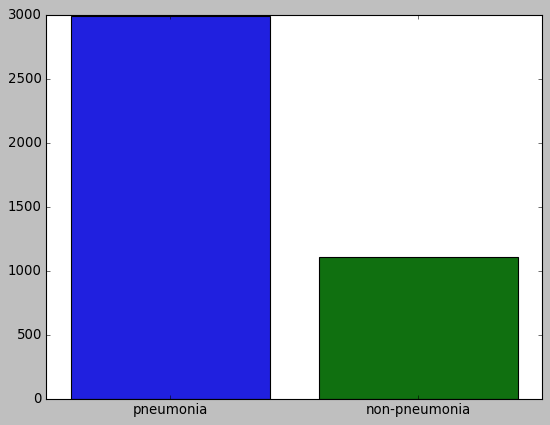

In [9]:
plt.style.use('classic')
sns.barplot(x=['pneumonia','non-pneumonia'], y=[train_pneum_df.shape[0], train_npneum_df.shape[0]])
#ax1.axhline(0, color="k", clip_on=False)
#ax1.set_ylabel("Sequential")

In [10]:
training_df = pd.DataFrame()
valid_df = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(train_df["fileName"],train_df["pneumonia"], test_size = 0.15, random_state = seed, 
                                                      stratify=train_df["pneumonia"])

training_df["fileName"], valid_df["fileName"], training_df["pneumonia"], valid_df["pneumonia"] = train_test_split(X_train,y_train, test_size = 0.15, 
                                                                                     random_state = seed, stratify=y_train)

In [11]:
neg = train_npneum_df.shape[0]
pos = train_pneum_df.shape[0]
total = neg+pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


In [12]:
img_size = (299)
batch_size = 14

rotation_range = 0
width_shift_range = 0
height_shift_range = 0
horizontal_flip = False
vertical_flip = False
shear_range = 0
zoom_range = 1

datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,vertical_flip=vertical_flip,
        fill_mode='nearest',rescale=1./255.)

#validation_split=0.15

train_iter=datagen.flow_from_dataframe(dataframe=training_df, directory=path+'/newimages/', 
                                       x_col="fileName", y_col="pneumonia", class_mode="raw", target_size=(img_size,img_size), color_mode='rgb', batch_size=batch_size)
valid_iter=datagen.flow_from_dataframe(dataframe=valid_df, directory=path+'/newimages/', 
                                           x_col="fileName", y_col="pneumonia", class_mode="raw", target_size=(img_size,img_size), color_mode='rgb', batch_size=batch_size)


Found 2961 validated image filenames.
Found 523 validated image filenames.


In [13]:
pretrained_model = Xception(include_top=False, weights="imagenet",input_shape=(img_size,img_size,3),)

In [14]:
pretrained_model.trainable = False

In [15]:
img_size = (299)

input_img = Input(shape=(img_size, img_size, 3))

xc = pretrained_model(input_img)

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='elu')(input_img)
#x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='elu')(x)
#x = BatchNormalization()(x)
#x = Concatenate(axis=-1)([input_img, x])
x = MaxPool2D(pool_size=(3, 3), strides=2)(x)

y = Conv2D(filters=64, kernel_size=3, padding='same', activation='elu')(x)
#y = BatchNormalization()(y)
y = Conv2D(filters=64, kernel_size=3, padding='same', activation='elu')(y)
#y = BatchNormalization()(y)
#y = Concatenate(axis=-1)([x, y])
y = MaxPool2D(pool_size=(3, 3), strides=2)(y)

z = Conv2D(filters=128, kernel_size=3, padding='same', activation='elu')(y)
#z = BatchNormalization()(z)
z = Conv2D(filters=128, kernel_size=3, padding='same', activation='elu')(z)
#z = BatchNormalization()(z)
#z = Concatenate(axis=-1)([y, z])
z = MaxPool2D(pool_size=(3, 3), strides=2)(z)

l = Conv2D(filters=256, kernel_size=3, padding='same', activation='elu')(z)
#l = BatchNormalization()(l)
l = Conv2D(filters=256, kernel_size=3, padding='same', activation='elu')(l)
#l = BatchNormalization()(l)
#l = Concatenate(axis=-1)([z, l])
l = MaxPool2D(pool_size=(3, 3), strides=2)(l)

m = Conv2D(filters=512, kernel_size=3, padding='same', activation='elu')(l)
#m = BatchNormalization()(m)
m = Conv2D(filters=512, kernel_size=3, padding='same', activation='elu')(m)
#m = BatchNormalization()(m)
#m = Concatenate(axis=-1)([l,m])
m = MaxPool2D(pool_size=(3, 3), strides=2)(m)

n = GlobalAveragePooling2D()(m)
nn = GlobalAveragePooling2D()(xc)

b = concatenate([n,nn])

f = Dense(4096, activation  =  'elu')(b)
#f = Dropout(rate=0.2, seed=42)(f)
f = Dense(2048, activation  =  'elu')(f)
f = Dense(1024, activation  =  'elu')(f)
#f = Dropout(rate=0.2, seed=42)(f)
f = Dense(512, activation  =  'elu')(f)
#f = Dropout(rate=0.2, seed=42)(f)
f = Dense(1, activation  =  'sigmoid')(f)

model = Model(inputs=input_img, outputs=f)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 299, 299, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 299, 299, 32) 9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 149, 149, 32) 0           conv2d_5[0][0]                   
______________________________________________________________________________________________

In [16]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
num_epochs = 300
learning_rate = 1e-4

weights_filepath = path_2+'model.29-06-2NNXCEP-run3-epo{epoch:02d}-f1{get_f1:.2f}.h5'

callbacks = [ModelCheckpoint(weights_filepath, monitor='get_f1', mode='max', verbose=2, save_best_only=True, save_freq='epoch'), 
             ReduceLROnPlateau(monitor="get_f1", factor=0.5, patience=10, verbose=2, mode="max", min_delta=0.01, cooldown=5, min_lr=0),
             EarlyStopping(monitor='get_f1', mode='max', patience=20, restore_best_weights=True)]
             #)]

#mse = MeanSquaredError()        

model.compile(loss = binary_crossentropy, optimizer = Adam(lr = learning_rate), metrics = ['acc', get_f1, "Precision", "Recall","AUC"])

In [19]:
#model.load_weights(path_2+'model.29-06-2-15-0.98.h5')

STEP_SIZE_TRAIN=train_iter.n//train_iter.batch_size
STEP_SIZE_VALID=valid_iter.n//valid_iter.batch_size

history = model.fit_generator(generator=train_iter, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_iter, 
                              validation_steps=STEP_SIZE_VALID, epochs=num_epochs, verbose = 2, callbacks=callbacks,class_weight=class_weight)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 211 steps, validate for 37 steps
Epoch 1/300

Epoch 00001: get_f1 improved from -inf to 0.80981, saving model to D:/UserFolders/Enak/Documentos/I2A2/Curso 2020/Desafio - Pneumonia Classification/NeuralNet_2Net_Xception/model.29-06-2NNXCEP-run3-epo01-f10.81.h5
211/211 - 171s - loss: 0.5072 - acc: 0.7618 - get_f1: 0.8098 - Precision: 0.8958 - Recall: 0.7614 - AUC: 0.8373 - val_loss: 0.5866 - val_acc: 0.6622 - val_get_f1: 0.7232 - val_Precision: 0.8691 - val_Recall: 0.6323 - val_AUC: 0.7640
Epoch 2/300

Epoch 00002: get_f1 improved from 0.80981 to 0.84328, saving model to D:/UserFolders/Enak/Documentos/I2A2/Curso 2020/Desafio - Pneumonia Classification/NeuralNet_2Net_Xception/model.29-06-2NNXCEP-run3-epo02-f10.84.h5
211/211 - 142s - loss: 0.4353 - acc: 0.7961 - get_f1: 0.8433 - Precision: 0.9193 - Recall: 0.7898 - AUC: 0.8809 - val_loss: 0.6189 - val_acc:

In [41]:
def print_graphics(history):
    
    plt.figure(figsize=(15, 15))
    plt.style.use('classic')

    plt.subplot(421)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('ACURÁCIA')
    plt.ylabel('acurácia')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.subplot(422)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.subplot(423)
    plt.plot(history.history['get_f1'])
    plt.plot(history.history['val_get_f1'])
    plt.title('get_f1')
    plt.ylabel('get_f1')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.subplot(424)
    plt.plot(history.history['AUC'])
    plt.plot(history.history['val_AUC'])
    plt.title('AUC')
    plt.ylabel('AUC')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.subplot(425)
    plt.plot(history.history['Precision'])
    plt.plot(history.history['val_Precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.subplot(426)
    plt.plot(history.history['Recall'])
    plt.plot(history.history['val_Recall'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc = 'upper left')
    
    plt.subplot(427)
    plt.plot(history.history['Recall'],history.history['Precision'])
    #plt.plot(history.history['val_Recall'],history.history['val_Precision'])
    plt.title('RecallxPrecision')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(['treino', 'validação'], loc = 'upper left')

    plt.show()

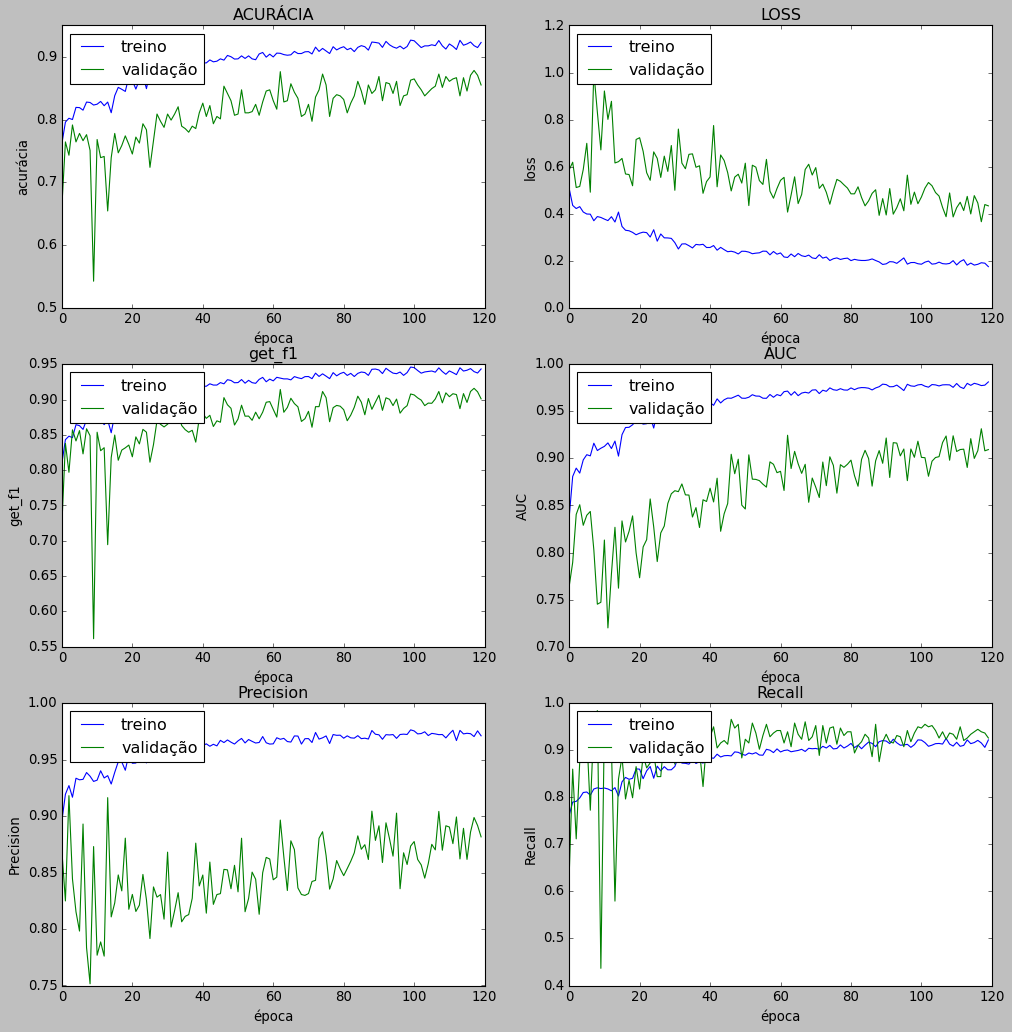

In [21]:
print_graphics(history)

In [33]:
num_epochs = 50
learning_rate = 1e-7
pretrained_model.trainable = True
model.compile(loss = binary_crossentropy, optimizer = Adam(lr = learning_rate), metrics = ['acc', get_f1, "Precision", "Recall","AUC"])



model.load_weights(path_2+'model.29-06-2NNXCEP-run3-epo02-f10.96.h5')

STEP_SIZE_TRAIN=train_iter.n//train_iter.batch_size
STEP_SIZE_VALID=valid_iter.n//valid_iter.batch_size

history = model.fit_generator(generator=train_iter, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_iter, validation_steps=STEP_SIZE_VALID, 
                              epochs=num_epochs, verbose = 2, callbacks=callbacks,class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 211 steps, validate for 37 steps
Epoch 1/50

Epoch 00001: get_f1 did not improve from 0.96238
211/211 - 258s - loss: 0.1882 - acc: 0.9192 - get_f1: 0.9407 - Precision: 0.9728 - Recall: 0.9149 - AUC: 0.9785 - val_loss: 0.2727 - val_acc: 0.8958 - val_get_f1: 0.9264 - val_Precision: 0.9378 - val_Recall: 0.9180 - val_AUC: 0.9578
Epoch 2/50

Epoch 00002: get_f1 did not improve from 0.96238
211/211 - 210s - loss: 0.1886 - acc: 0.9179 - get_f1: 0.9394 - Precision: 0.9695 - Recall: 0.9162 - AUC: 0.9788 - val_loss: 0.2851 - val_acc: 0.9093 - val_get_f1: 0.9373 - val_Precision: 0.9276 - val_Recall: 0.9497 - val_AUC: 0.9657
Epoch 3/50

Epoch 00003: get_f1 did not improve from 0.96238
211/211 - 211s - loss: 0.1863 - acc: 0.9250 - get_f1: 0.9447 - Precision: 0.9744 - Recall: 0.9214 - AUC: 0.9791 - val_loss: 0.2535 - val_acc: 0.9112 - val_get_f1: 0.9369 - val_Precision: 0.9536 - val_Recall: 0.9233 - val_AUC: 0.9647
Epoch 4/50

Epoch 00004: 

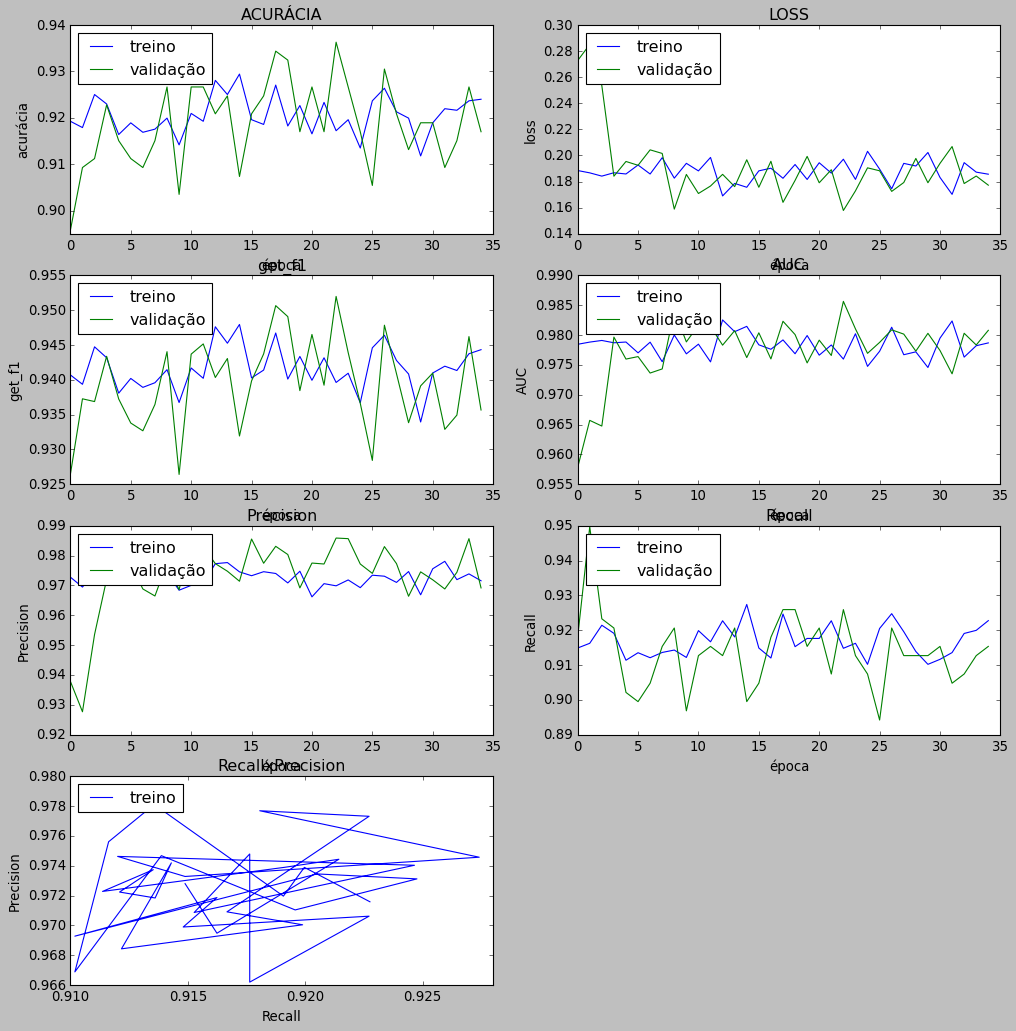

In [42]:
print_graphics(history)

In [43]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [44]:
def model_prediction(X_data):
    X = []
    
    for i in tqdm(X_data):
        im = Image.open(path+'/images/'+i).convert("RGB")
        im = im.resize((img_size,img_size))
        im = np.asarray(im)/255
        #im = np.expand_dims(im, axis=2)
        X.append(im)
    
    X_tt = np.stack(X,axis=0) 

    return np.rint(model.predict(X_tt,verbose=1))

In [ ]:
y_predict = model_prediction(training_df['fileName'])
plot_roc("Train Baseline", training_df['pneumonia'], y_predict, color='blue')
#plot_roc("Test Baseline", valid_iter[1][0], np.rint(model.predict(valid_iter[0])), color='blue', linestyle='--')
plt.legend(loc='lower right')

 77%|████████████████████████████████████████████████████████████▏                 | 2286/2961 [01:18<00:39, 17.28it/s]

In [31]:
y_predict = model_prediction(X_test)
model.evaluate(X_test, y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 615/615 [00:30<00:00, 19.88it/s]


MemoryError: Unable to allocate 1.23 GiB for an array with shape (615, 299, 299, 3) and data type float64

In [30]:
fbeta_score(y_predict, y_test,beta=0.5,average='binary')

0.9388097233864208

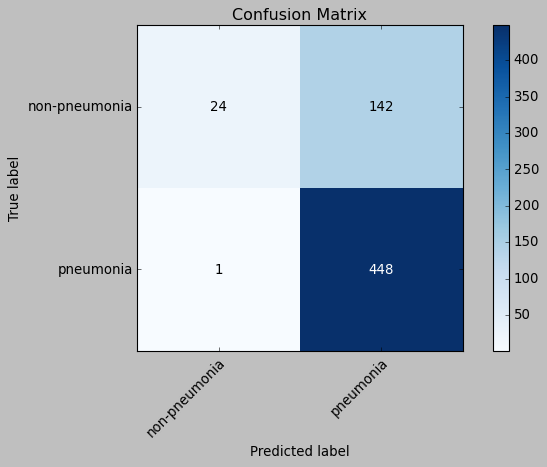

In [32]:
cm = confusion_matrix(y_test, y_predict)

plt.style.use('classic')

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=['non-pneumonia','pneumonia'], yticklabels=['non-pneumonia','pneumonia'], title='Confusion Matrix',ylabel='True label',xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
normalize=True
    # Loop over data dimensions and create text annotations.
fmt = 'd'#'.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")

        fig.tight_layout()

plt.show()

In [ ]:

#model = load_model(path_2+'model.27-06-80-1.00.h5')
model.load_weights(path_2+'model.29-06-2-15-0.98.h5')
y_predict = model_prediction(test_df['fileName'])

In [ ]:
test_df['pneumonia'] = y_predict

In [ ]:
test_df.to_csv(path+'NeuralNet_2Net_Xception/submission_6.csv',index=False)